In [1]:
import random
import numpy as np
import torch
import polars as pl
from tqdm import tqdm
from matplotlib import pyplot as plt
import warnings
from typing import Optional

from subset_bo import get_next_query_by_ei, get_next_query_by_mo
from p_median import obj, solve_by_mip

/mnt/d/repos/set_bo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def single_experiment(
    features: torch.Tensor,
    n_init_repeat: int,
    n_total_query: int,
    target_size_min: int,
    target_size_max: int,
    seed: int,
    method: str,
    beam_width: Optional[int] = None,
) -> pl.DataFrame:
    set_seed(seed)

    history = []

    # get initial queries
    train_x = []
    for _ in range(n_init_repeat):
        for n in range(target_size_min, target_size_max + 1):
            tmp = random.sample(range(len(features)), n)
            tmp_x = [0 for _ in range(len(features))]
            for i in tmp:
                tmp_x[i] = 1
            train_x.append(tmp_x)
        train_x = torch.Tensor(train_x).to(dtype=torch.float64)
        train_y = [obj(features, x.tolist()) for x in train_x]
        train_y = torch.Tensor(train_y).reshape(-1, 1).to(train_x)
    
    for i in range(train_x.shape[0]):
        history.append({
            "t": len(history),
            "try_x": train_x[i].tolist(),
            "try_acqfval": float("nan"),
            "try_obs": train_y[i].item(),
        })

    for i in tqdm(range(n_total_query - len(history))):
        if method == "ei":
            next, next_acqfval = get_next_query_by_ei(
                features=features,
                train_x=train_x,
                train_y=train_y,
                min_num=target_size_min,
                max_num=target_size_max,
                beam_width=beam_width,
            )
        elif method == "ei_rotate":
            cur_size = i % (target_size_max - target_size_min + 1) + target_size_min
            next, next_acqfval = get_next_query_by_ei(
                features=features,
                train_x=train_x,
                train_y=train_y,
                min_num=cur_size,
                max_num=cur_size,
                beam_width=beam_width,
            )
        elif method == "mo":
            next, next_acqfval = get_next_query_by_mo(
                features=features,
                train_x=train_x,
                train_y=train_y,
                min_num=target_size_min,
                max_num=target_size_max,
                beam_width=beam_width,
            )
        else:
            assert method == "random"
            cur_size = random.randint(target_size_min, target_size_max)
            next = [0 for _ in range(len(features))]
            for i in random.sample(range(len(features)), cur_size):
                next[i] = 1
            next_acqfval = float("nan")
        observed = obj(features, next)

        train_x = torch.cat([train_x, torch.Tensor(next).reshape(1, -1).to(train_x)])
        train_y = torch.cat([train_y, torch.Tensor([[observed]]).to(train_x)])

        info = {
            "t": len(history),
            "try_x": next,
            "try_acqfval": next_acqfval,
            "try_obs": observed
        }
        history.append(info)

    df = pl.DataFrame(history)
    df = df.with_columns(
        try_len=pl.col("try_x").map_elements(lambda x: int(sum(x)), return_dtype=int)
    ).with_columns(
        best=pl.col("try_obs").cum_min().over("try_len", order_by="t")
    ).with_columns(
        method=pl.lit(method),
        seed=pl.lit(seed)
    )

    return df

In [3]:
warnings.filterwarnings(
    "ignore",
    message="Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06."
)

In [4]:
features = []
dfs = []
for seed in range(10):
    set_seed(seed)
    tmp_features = torch.rand(size=(100, 2))
    features.append(tmp_features)
    for method in ["random", "ei", "ei_rotate", "mo"]:
        df = single_experiment(
            features=tmp_features,
            n_init_repeat=1,
            n_total_query=100,
            target_size_min=3,
            target_size_max=7,
            seed=seed,
            method=method,
            beam_width=5
        )
        dfs.append(df)

100%|██████████| 95/95 [00:59<00:00,  1.60it/s]


In [5]:
df = pl.concat(dfs)

In [6]:
opt_res = []
for seed in range(len(features)):
    tmp_features = features[seed]
    for n in range(df["try_len"].min(), df["try_len"].max() + 1):
        tmp_obj, tmp_sol = solve_by_mip(tmp_features, n)
        opt_res.append({
            "seed": seed,
            "try_len": n,
            "obj": tmp_obj,
            "center_idx": tmp_sol
        })
opt_res = pl.DataFrame(opt_res)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /mnt/d/repos/set_bo/.venv/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5794f5b3dea5476da888fc1db6767337-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/5794f5b3dea5476da888fc1db6767337-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10106 COLUMNS
At line 70307 RHS
At line 80409 BOUNDS
At line 90510 ENDATA
Problem MODEL has 10101 rows, 10100 columns and 30100 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22.8943 - 0.29 seconds
Cgl0004I processed model has 10101 rows, 10100 columns (10100 integer (10100 of which binary)) and 30100 elements
Cbc0038I Initial state - 309 integers unsatisfied sum - 103
Cbc0038I Pass   1: (1.24 seconds) suminf.  102.01730 (1154) obj. 50.9727 iterations 6577
Cbc0038I Pass   2: (1.43 seconds) suminf.    0.00000 (0) obj. 

In [7]:
df = df.join(opt_res.with_columns(pl.col("seed").cast(pl.Int32)), on=["seed", "try_len"], how="left").rename({
    "obj": "opt_obj",
    "center_idx": "opt_center_idx"
}).with_columns(
    best_relative_perf=pl.col("best") / pl.col("opt_obj"),
)

In [11]:
df.write_parquet("mo_comparison_result.parquet")

In [8]:
pl.Config.set_tbl_rows(100)

polars.config.Config

In [12]:
df_min = df.group_by(["method", "try_len", "seed"]).agg(
    pl.col("best_relative_perf").min()
)

In [18]:
df.group_by(["method", "try_len", "seed", "t"]).agg(
    pl.col("best_relative_perf").min()
).group_by(["method", "try_len", "t"]).agg(
    min_best_perf=pl.col("best_relative_perf").min(),
    avg_best_perf=pl.col("best_relative_perf").mean(),
    max_best_perf=pl.col("best_relative_perf").max()
).sort(["method", "try_len", "t"]).head()

method,try_len,t,min_best_perf,avg_best_perf,max_best_perf
str,i64,i64,f64,f64,f64
"""ei""",3,0,1.238604,1.500175,2.171625
"""ei""",3,13,1.238604,1.238604,1.238604
"""ei""",3,14,1.311909,1.45068,1.589451
"""ei""",3,18,1.248986,1.287613,1.326239
"""ei""",3,20,1.311909,1.311909,1.311909


In [19]:
import seaborn as sns

In [20]:
df_summary = df_min.group_by(["method", "try_len"]).agg(
    min_best_perf=pl.col("best_relative_perf").min(),
    avg_best_perf=pl.col("best_relative_perf").mean(),
    max_best_perf=pl.col("best_relative_perf").max()
).sort("try_len", "method")

method,try_len,min_best_perf,avg_best_perf,max_best_perf
str,i64,f64,f64,f64
"""ei""",3,1.054988,1.308532,1.939531
"""ei_rotate""",3,1.003245,1.03155,1.057331
"""mo""",3,1.000355,1.029127,1.070535
"""random""",3,1.042654,1.099166,1.185912
"""ei""",4,1.190279,1.292458,1.414955


/tmp/ipykernel_24235/1084189411.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  data=df_min.with_columns(


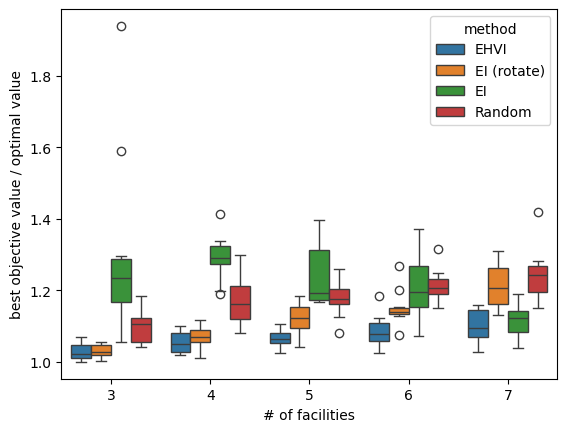

In [30]:
sns.boxplot(
    data=df_min.with_columns(
        method=pl.col("method").map_elements(
            lambda x: {
                "random": "Random",
                "ei": "EI",
                "ei_rotate": "EI (rotate)",
                "mo": "EHVI"
            }[x]
        )
    ),
    x="try_len",
    y="best_relative_perf",
    hue="method"
)
plt.xlabel("# of facilities")
plt.ylabel("best objective value / optimal value")
plt.show()